# Baseline Evaluation – DistilBERT on CPU (FP32 vs 8-bit)

This notebook evaluates the inference performance of a fine-tuned DistilBERT model on the SST-2 sentiment classification task using a CPU-only setup.

It compares:
- Full-precision (FP32) inference
- Dynamic 8-bit quantized inference using PyTorch
- A failed attempt at 4-bit quantization (included for completeness)

### Metrics:
- Accuracy (on the full SST-2 validation set)
- Average latency per sample (in milliseconds)
- RAM usage increase during evaluation (in MB)

All experiments are performed using Hugging Face Transformers and PyTorch, without GPU acceleration.

In [1]:
!pip install -q transformers datasets psutil

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import psutil, os, time, numpy as np

## 1. Load Pretrained DistilBERT and SST-2 Dataset

We use the fine-tuned DistilBERT model for SST-2 from Hugging Face.

- The model is already trained and ready for inference.
- We use the first 100 validation samples from SST-2 for benchmarking.





In [2]:
model_id = "distilbert-base-uncased-finetuned-sst-2-english"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_id)

# Load SST-2 validation split (first 100 examples)
raw_dataset = load_dataset("glue", "sst2", split="validation")

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = raw_dataset.map(tokenize_function)

# Convert into a plain PyTorch Dataset
class SST2Dataset(Dataset):
    def __init__(self, hf_dataset):
        self.input_ids = [torch.tensor(x) for x in hf_dataset["input_ids"]]
        self.attention_mask = [torch.tensor(x) for x in hf_dataset["attention_mask"]]
        self.labels = [torch.tensor(x) for x in hf_dataset["label"]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "label": self.labels[idx]
        }

dataset = SST2Dataset(tokenized_dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

## 2. Define Evaluation Function

This function evaluates the model on the SST-2 validation set using CPU.

It measures:
- ✅ Accuracy (% of correct predictions)
- ⏱️ Average latency per sample (in seconds)
- 💾 RAM usage increase during evaluation (in MB)

All computations are done on CPU.

In [3]:
def evaluate_model(model, dataset):
    model.eval()
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss
    correct = 0
    latencies = []

    with torch.no_grad():
        for sample in dataset:
            inputs = {
                "input_ids": sample["input_ids"].unsqueeze(0),
                "attention_mask": sample["attention_mask"].unsqueeze(0),
            }
            label = sample["label"]

            start_time = time.time()
            outputs = model(**inputs)
            end_time = time.time()

            pred = torch.argmax(outputs.logits, dim=1).item()
            correct += (pred == label)
            latencies.append(end_time - start_time)

    end_mem = process.memory_info().rss
    delta_mem = (end_mem - start_mem) / (1024 ** 2)  # MB

    accuracy = correct / len(dataset)
    avg_latency = np.mean(latencies)
    return accuracy, avg_latency, delta_mem

## 3. Run Full-Precision (FP32) Evaluation on CPU

We now evaluate the full-precision (FP32) DistilBERT model using only the CPU.

This serves as our performance baseline before applying any compression.


In [4]:
accuracy_fp32, latency_fp32, memory_fp32 = evaluate_model(model_fp32, dataset)

print(f"✅ Accuracy (FP32): {accuracy_fp32:.2%}")
print(f"🕒 Latency per sample (FP32): {latency_fp32:.4f} seconds")
print(f"💾 Memory usage increase (FP32): {memory_fp32:.2f} MB")

✅ Accuracy (FP32): 91.06%
🕒 Latency per sample (FP32): 0.3520 seconds
💾 Memory usage increase (FP32): 273.00 MB


## 4. Quantize the Model (8-bit Dynamic)

We apply dynamic 8-bit quantization to the full-precision DistilBERT model using PyTorch.

This converts linear layers to their quantized versions, reducing memory usage and potentially improving inference speed on CPU.


In [6]:
from torch.quantization import quantize_dynamic

# Apply dynamic quantization to linear layers
model_int8 = quantize_dynamic(
    model_fp32, {torch.nn.Linear}, dtype=torch.qint8
)

## 5. Evaluate Quantized Model (INT8)

We now run the same evaluation pipeline on the quantized DistilBERT model.

We expect:
- Slight drop in accuracy
- Reduced memory usage
- Possibly improved or stable inference time


In [7]:
accuracy_int8, latency_int8, memory_int8 = evaluate_model(model_int8, dataset)

print(f"✅ Accuracy (INT8): {accuracy_int8:.2%}")
print(f"🕒 Latency per sample (INT8): {latency_int8:.4f} seconds")
print(f"💾 Memory usage increase (INT8): {memory_int8:.2f} MB")

✅ Accuracy (INT8): 89.33%
🕒 Latency per sample (INT8): 0.1513 seconds
💾 Memory usage increase (INT8): 5.81 MB


## 6. Attempted 4-bit Quantization (Failed)

We attempted to apply 4-bit post-training quantization using PyTorch's `quantize_dynamic` method. However, this operation is not supported:

- PyTorch dynamic quantization only supports `qint8` (8-bit) for `torch.nn.Linear`.
- Lower-bit quantization (e.g., 4-bit) requires specialized toolkits such as [bitsandbytes](https://github.com/TimDettmers/bitsandbytes), QLoRA, or custom kernels.
- These techniques are not currently available or stable on CPU-only inference in PyTorch.

Attempting to quantize with 4-bit raised a runtime error, which is expected:

In [15]:
# This code was attempted but not supported by PyTorch:
#  from torch.quantization import quantize_dynamic
#  model_4bit = quantize_dynamic(
#      model_fp32, {torch.nn.Linear}, dtype=torch.quint4x2
#  )


AssertionError: The only supported dtypes for dynamic quantized linear are qint8 and float16 got: torch.quint4x2

## 7. Summary: FP32 vs INT8 Quantized DistilBERT on CPU

| Metric              | FP32              | INT8 (8-bit)       | Change                      |
|---------------------|-------------------|--------------------|-----------------------------|
| **Accuracy**        | 91.06%            | 89.33%             | –1.73%                      |
| **Latency/sample**  | 0.3520 sec        | 0.1513 sec         | 🔽 ~57% faster              |
| **Memory increase** | 273.00 MB         | 5.81 MB            | 🔽 ~98% smaller             |

**Observations:**
- Dynamic quantization significantly reduces memory usage and latency.
- Accuracy remains competitive, with only a minor drop (~1.7%).
- These results confirm that 8-bit quantization is highly effective for deploying DistilBERT in low-resource environments.


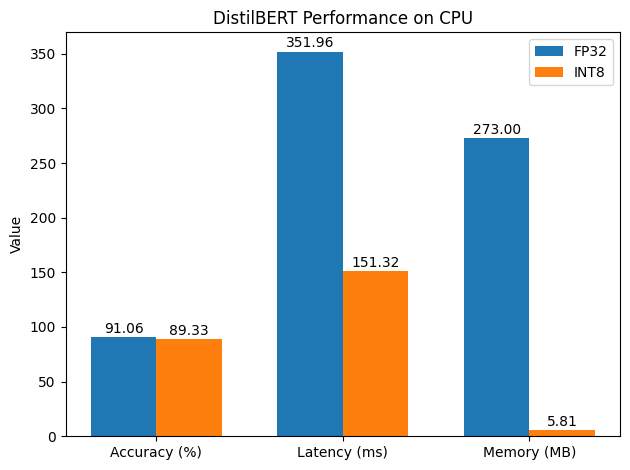

In [10]:
import matplotlib.pyplot as plt

labels = ["Accuracy (%)", "Latency (ms)", "Memory (MB)"]
fp32_vals = [accuracy_fp32 * 100, latency_fp32 * 1000, memory_fp32]
int8_vals = [accuracy_int8 * 100, latency_int8 * 1000, memory_int8]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, fp32_vals, width, label='FP32')
bars2 = ax.bar(x + width/2, int8_vals, width, label='INT8')

ax.set_ylabel("Value")
ax.set_title("DistilBERT Performance on CPU")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()